In [1]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import spatialproteomics as sp
import matplotlib.pyplot as plt
import tifffile
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
from glob import glob
from tqdm.auto import tqdm
from adjustText import adjust_text
import os
import matplotlib.ticker as ticker

In [2]:
# Load the custom style
mpl.style.core.use('pub_matplotlib_rc.ini')

# Define base path
base_path = "/g/huber/users/meyerben/data/codex/BNHL/data_for_publication/derived_data"

# Define colors
entity_class_colors = {
    'LN': '#9dcbec',
    'indolent': '#E2AFAC',
    'aggressive': '#741815'
}

celltype_colors = {
    'B cell': '#5799d1',
    'T cell': '#ebc850',
    'Myeloid cell': '#de6866',
    'Dendritic cell': '#4cbcbd',
    'Macrophage': '#bb7cb4',
    'Stromal cell': '#62b346',
    'Endothelial cell': '#bf997d'
}

neighborhood_colors = {
    'B': '#5799d1',
    'B_prol/T_fh': '#154e91',
    'T/Dendritic': '#fef1c3',
    'T': '#ebc850',
    'T_h/T_reg': '#cca02d',
    'Myeloid/Macro': '#de6866',
    'Mixed': '#c8ceda'
}

nh_mapping_dict = {
    'Neighborhood 0': 'T/Dendritic',
    'Neighborhood 1': 'T',
    'Neighborhood 2': 'Mixed',
    'Neighborhood 3': 'B_prol/T_fh',
    'Neighborhood 4': 'T_h/T_reg',
    'Neighborhood 5': 'B',
    'Neighborhood 6': 'Myeloid/Macro'
}

entity_grouping_dict = {
    'LN': 'LN',
    'FL 1': 'indolent',
    'FL 2': 'indolent',
    'FL 3a': 'indolent',
    'FL 3b': 'indolent',
    'MZL': 'indolent',
    'DLBCL': 'aggressive',
    'Burkitt': 'aggressive',
    'PMBCL': 'aggressive',
    'BLBL': 'aggressive'
}

all_cts = [
    'B cell', 'B_prol', 'T cell', 'T_h', 'T_h_mem', 'T_h_naive', 'T_reg', 'T_fh',
    'T_reg_Helios', 'T_tox', 'T_exh', 'T_progenitor_exh', 'T_terminally_exh',
    'T_tox_naive', 'T_tox_mem', 'Myeloid cell', 'Dendritic cell',
    'Macrophage', 'M2', 'Stromal cell', 'Endothelial cell'
]

all_nhs = list(neighborhood_colors.keys())

In [4]:
# Load data
metadata = pd.read_csv(f"{base_path}/tma_metadata.csv", index_col=0)
files = glob(f"{base_path}/tmas/*")

nh_composition_df = pd.read_csv(f"{base_path}/neighborhood_composition.csv", index_col=0)
celltype_abundance_df = pd.read_csv(f"{base_path}/celltype_abundance.csv", index_col=0)

celltype_abundance_df['Entity_Class'] = pd.Categorical(
    celltype_abundance_df['Entity_Class'],
    categories=['LN', 'indolent', 'aggressive'],
    ordered=True
)
celltype_abundance_df = celltype_abundance_df.sort_values(by=['Entity_Class', 'B cell'])

lda_loading_df = pd.read_csv(f"{base_path}/lda_loadings.csv", index_col=0)
lda_df = pd.read_csv(f"{base_path}/lda_df.csv", index_col=0)
lda_explained_variance = pd.read_csv(f"{base_path}/lda_ev.csv", index_col=0)
df_degree_size = pd.read_csv(f"{base_path}/degree_size_df.csv", index_col=0)

# Load zarr dataset (updated name)
ds = xr.open_zarr(f"{base_path}/../tmas_unzipped/LN_28_2.zarr")

# Filter nh_mapping_dict based on available neighborhoods in the dataset
available_nhs = ds.pp.get_layer_as_df()['_neighborhoods'].unique()
nh_mapping_dict_tmp = {k: v for k, v in nh_mapping_dict.items() if k in available_nhs}

In [5]:
point_size = 35

def plot_cell_types(ax, render_legend=False, ds=ds):
    coarse_cts = ds.pp.get_layer_as_df('_la_layers')
    coarse_cts['cell'] = coarse_cts.index
    ds = ds.pp.drop_layers(['_la_properties', '_neighborhoods']).la.add_labels_from_dataframe(coarse_cts, label_col='labels_0').la.set_label_colors(celltype_colors.keys(), celltype_colors.values())
    _ = ds.pl.autocrop().pl.show(render_image=False, render_labels=True, background='white', ax=ax, legend_label=render_legend)
    # Remove the borders
    ax.spines['top'].set_visible(False)    # Hide the top spine
    ax.spines['right'].set_visible(False)  # Hide the right spine
    ax.spines['left'].set_visible(False)   # Hide the left spine
    ax.spines['bottom'].set_visible(False) # Hide the bottom spine
    # Optionally, hide ticks if desired
    ax.set_xticks([])
    ax.set_yticks([])
    
def plot_neighborhoods(ax, render_legend=False, ds=ds):
    _ = ds.nh.set_neighborhood_name(list(nh_mapping_dict_tmp.keys()), list(nh_mapping_dict_tmp.values())).nh.set_neighborhood_colors(neighborhood_colors.keys(), neighborhood_colors.values()).pl.autocrop().pl.show(render_image=False, render_neighborhoods=True, background='white', ax=ax, legend_neighborhoods=render_legend)
    # _ = ds.pl.autocrop().pl.show(render_image=False, render_neighborhoods=True, background='white', ax=ax, legend_neighborhoods=render_legend)
    # Remove the borders
    ax.spines['top'].set_visible(False)    # Hide the top spine
    ax.spines['right'].set_visible(False)  # Hide the right spine
    ax.spines['left'].set_visible(False)   # Hide the left spine
    ax.spines['bottom'].set_visible(False) # Hide the bottom spine
    # Optionally, hide ticks if desired
    ax.set_xticks([])
    ax.set_yticks([])
    
def plot_diversity(ax, render_legend=False, ds=ds):
    _ = ds.pl.autocrop().pl.render_obs(feature="diversity_index", cmap="plasma", background='white').pl.imshow(legend_obs=render_legend, ax=ax)
    # Remove the borders
    ax.spines['top'].set_visible(False)    # Hide the top spine
    ax.spines['right'].set_visible(False)  # Hide the right spine
    ax.spines['left'].set_visible(False)   # Hide the left spine
    ax.spines['bottom'].set_visible(False) # Hide the bottom spine
    # Optionally, hide ticks if desired
    ax.set_xticks([])
    ax.set_yticks([])
    
def plot_entity_overview(ax):
    entity_column = 'Entity'
    entity_color_map = nh_composition_df[entity_column].map(entity_colors)
    for i, color in enumerate(entity_color_map):
        ax.add_patch(plt.Rectangle((0, i), 1, 1, color=color))

    # Compute spans for each entity
    entity_groups = nh_composition_df.groupby(entity_column).indices
    
    # Add centered text for each entity
    for i, (entity, indices) in enumerate(entity_groups.items()):
        start = min(indices)
        end = max(indices) + 1
        center = (start + end) / 2
        count = len(indices)
        text_color = "white" if i >= 8 else "black"
        ax.text(
            0.5,
            center,
            f"{entity}",
            ha="center",
            va="center",
            color=text_color,
        )

    ax.set_ylim(0, len(nh_composition_df))
    ax.set_xlim(0, 1)
    ax.invert_yaxis()
    # Remove the borders
    ax.spines['top'].set_visible(False)    # Hide the top spine
    ax.spines['right'].set_visible(False)  # Hide the right spine
    ax.spines['left'].set_visible(False)   # Hide the left spine
    ax.spines['bottom'].set_visible(False) # Hide the bottom spine
    # Optionally, hide ticks if desired
    ax.set_xticks([])
    ax.set_yticks([])
    
def plot_entity_class_overview(ax):
    entity_column = 'Entity_Class'
    entity_color_map = celltype_abundance_df[entity_column].map(entity_class_colors)
    for i, color in enumerate(entity_color_map):
        ax.add_patch(plt.Rectangle((0, i), 1, 1, color=color))

    # Compute spans for each entity
    entity_groups = celltype_abundance_df.groupby(entity_column).indices
        
    # Add centered text for each entity
    for i, (entity, indices) in enumerate(entity_groups.items()):
        if len(indices) == 0:
            continue
        start = min(indices)
        end = max(indices) + 1
        center = (start + end) / 2
        count = len(indices)
        text_color = "white" if i == 2 else "black"
        ax.text(
            0.5,
            center,
            f"{entity}",
            ha="center",
            va="center",
            color=text_color,
            rotation=90
        )

    ax.set_ylim(0, len(celltype_abundance_df))
    ax.set_xlim(0, 1)
    ax.invert_yaxis()
    # Remove the borders
    ax.spines['top'].set_visible(False)    # Hide the top spine
    ax.spines['right'].set_visible(False)  # Hide the right spine
    ax.spines['left'].set_visible(False)   # Hide the left spine
    ax.spines['bottom'].set_visible(False) # Hide the bottom spine
    # Optionally, hide ticks if desired
    ax.set_xticks([])
    ax.set_yticks([])
    
def plot_ct_abundance_overview(ax):
    celltype_abundance_df[celltype_colors.keys()].plot(
        kind="barh",
        stacked=True,
        ax=ax,
        color=celltype_colors,
        legend=False,
        width=1
    )
    ax.set_ylim(0, len(celltype_abundance_df))
    ax.invert_yaxis()
    # Remove the borders
    ax.spines['top'].set_visible(False)    # Hide the top spine
    ax.spines['right'].set_visible(False)  # Hide the right spine
    ax.spines['left'].set_visible(False)   # Hide the left spine
    ax.spines['bottom'].set_visible(False) # Hide the bottom spine
    # Optionally, hide ticks if desired
    ax.set_xticks([])
    ax.set_yticks([])
    
    
# Format x-axis ticks to show 8k, 10k, etc.
def format_ticks(x, pos):
    if x >= 1000:
        return f'{int(x/1000)}k'
    return str(int(x))    

def plot_cell_sizes(ax):
    sns.scatterplot(
        df_degree_size, 
        x='num_cells', 
        y='area', 
        hue='entity', 
        palette=entity_colors, 
        legend=False,
        ax=ax,
        s=point_size
    )

    # Add labels for each point
    texts = []
    for _, row in df_degree_size.iterrows():
        texts.append(
            ax.text(
                row['num_cells'], 
                row['area'], 
                row['entity'], 
                ha='center', 
                va='center'
            )
        )

    # Adjust text positions to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5), ax=ax)

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))

    # Remove the right and top splines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Add labels
    ax.set_xlabel('Mean number of cells')
    ax.set_ylabel('Mean cell area')
    
    ax.set_yticks([160, 170, 180, 190, 200])
    
def plot_neighborhood_composition(ax):
    sns.heatmap(
        nh_composition_df,
        cmap="coolwarm",
        #cbar_pos=(1.02, 0.2, 0.03, 0.77),  # Position the colorbar to the right of the heatmap
        annot=False,  # No annotation
        center=0,  # Setting the center of the colorbar to 0
        linewidth=0.3,
        ax=ax
    )
    
    ax.set_ylabel('Neighborhood')
    # rotating the x tick labels
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')  # or 'left', 'center'
        label.set_verticalalignment('top')  # or 'bottom', 'center'
    
def plot_lda(ax):
    sns.scatterplot(data=lda_df, x='LD1', y='LD2', hue='entity_class', palette=entity_class_colors, s=point_size, ax=ax, legend=False)
    ax.set_xlabel(f'LD1 ({lda_explained_variance.iloc[0,0]:.2f}%)')
    ax.set_ylabel(f'LD2 ({lda_explained_variance.iloc[1,0]:.2f}%)')
    
    # Remove the right and top splines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_yticks([-4, -2, 0, 2, 4])
    
def plot_lda_loadings(ax):
    # Filter out rows where the absolute value of LD1 is below 0.5
    filtered_df = lda_loading_df[lda_loading_df['LD1'].abs() >= 0.5]
    
    # Get the color map
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    
    # Normalize the data for coloring
    norm = plt.Normalize(vmin=filtered_df['LD1'].min(), vmax=filtered_df['LD1'].max())
    
    # Set y-ticks to match the index and center them vertically
    ax.set_yticks(np.arange(len(filtered_df)))
    ax.set_yticklabels(filtered_df.index)
    
    # Draw lines from 0 to the value for each point (plot lines first to be behind)
    for i, row in filtered_df.iterrows():
        ax.plot([0, row['LD1']], [i, i], color='#98a2b5', lw=1, zorder=1)
    
    # Scatter plot with color mapping and outlines around points
    scatter = ax.scatter(filtered_df['LD1'], np.arange(len(filtered_df)), 
                         c=filtered_df['LD1'], cmap=cmap, s=20, 
                         edgecolor='black', linewidth=1, norm=norm, zorder=2)
    
    # Set labels
    ax.set_xlabel('Scaling')
    ax.set_ylabel('')
    
    # Remove the right and top splines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# Individual subplots
The figure should have maximum dimensions of 8.3, 11.7.

In [6]:
font_size = 6.5
point_size = 20
point_border_color = '#49566d'  # dark gray
line_width = 0.6

# Set global font size
plt.rcParams.update({"font.size": font_size})  # Adjust the value as needed

Removing labels from observations. If you want to keep the labels in the obs layer, set drop_obs=False.


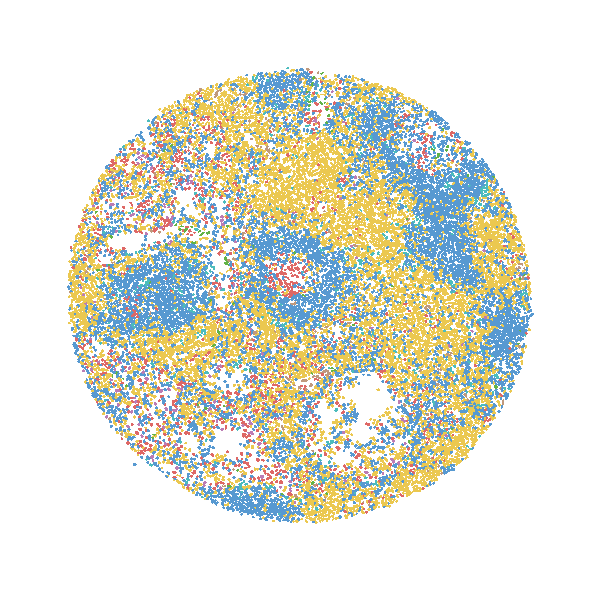

In [7]:
def plot_cell_types(ax, render_legend=False, ds=ds):
    coarse_cts = ds.pp.get_layer_as_df('_la_layers')
    coarse_cts['cell'] = coarse_cts.index
    ds = ds.pp.drop_layers(['_la_properties', '_neighborhoods']).la.add_labels_from_dataframe(coarse_cts, label_col='labels_0').la.set_label_colors(celltype_colors.keys(), celltype_colors.values())
    _ = ds.pl.autocrop().pl.show(render_image=False, render_labels=True, background='white', ax=ax, legend_label=render_legend)
    
    # Remove the borders
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Remove ticks and padding
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.margins(0)  # Remove padding
    ax.set_frame_on(False)  # Optional: Removes the entire frame

plt.figure(figsize=(1, 1), dpi=600)
ax = plt.gca()
plot_cell_types(ax)
plt.tight_layout()

Neighborhood T/Dendritic not found in the data object. Skipping.


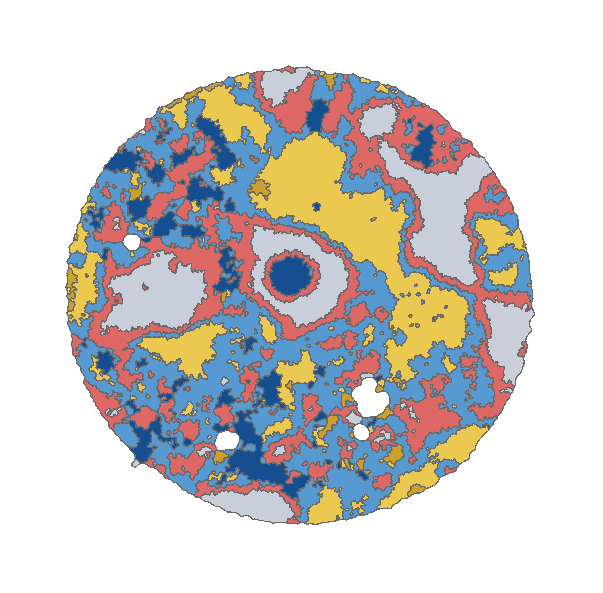

In [8]:
plt.figure(figsize=(1, 1), dpi=600)
ax = plt.gca()
plot_neighborhoods(ax)
plt.tight_layout()

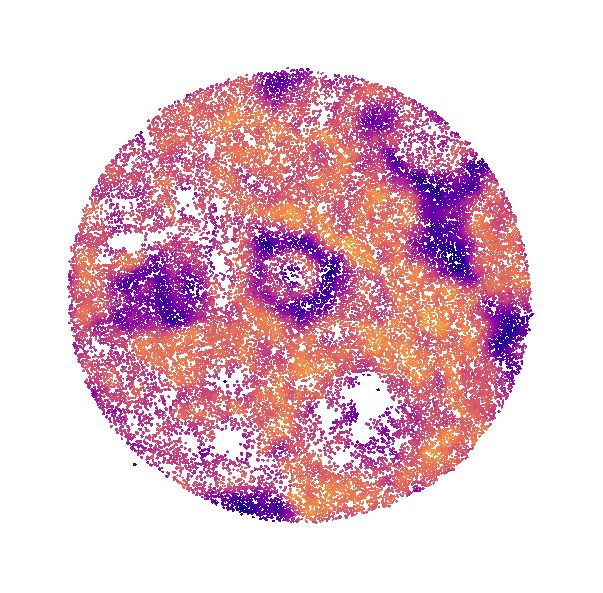

In [9]:
def plot_diversity(ax, render_legend=False, ds=ds):
    _ = ds.pl.autocrop().pl.render_obs(feature="diversity_index", cmap="plasma", background='white', vmin=0, vmax=3).pl.imshow(legend_obs=render_legend, ax=ax)
    # Remove the borders
    ax.spines['top'].set_visible(False)    # Hide the top spine
    ax.spines['right'].set_visible(False)  # Hide the right spine
    ax.spines['left'].set_visible(False)   # Hide the left spine
    ax.spines['bottom'].set_visible(False) # Hide the bottom spine
    # Optionally, hide ticks if desired
    ax.set_xticks([])
    ax.set_yticks([])
    
    
plt.figure(figsize=(1, 1), dpi=600)
ax = plt.gca()
plot_diversity(ax)
# plt.title('Diversity Index')
plt.tight_layout()

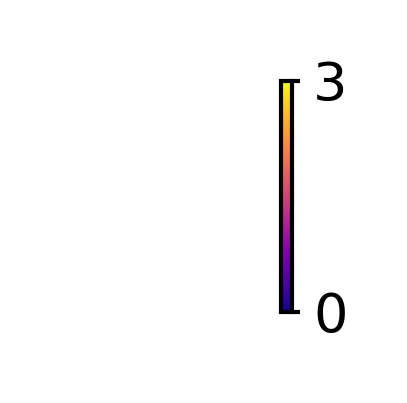

In [10]:
import matplotlib.colors as mcolors

# Create a figure and axis
fig, ax = plt.subplots(figsize=(0.5, 0.5), dpi=600)

# Create a ScalarMappable to set the color range and colormap
norm = mcolors.Normalize(vmin=0, vmax=3)
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])  # Set an empty array since we only need the colorbar

# Add the colorbar to the plot with specific width and ticks
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.05, pad=0.04)  # Adjust fraction for width

# Set ticks manually
cbar.set_ticks([0, 3])
for tick in cbar.ax.get_yticklabels():
    tick.set_fontsize(font_size)
# Remove the axis ticks and spines
ax.set_axis_off()

/tmp/ipykernel_10153/99702777.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  entity_groups = celltype_abundance_df.groupby(entity_column).indices


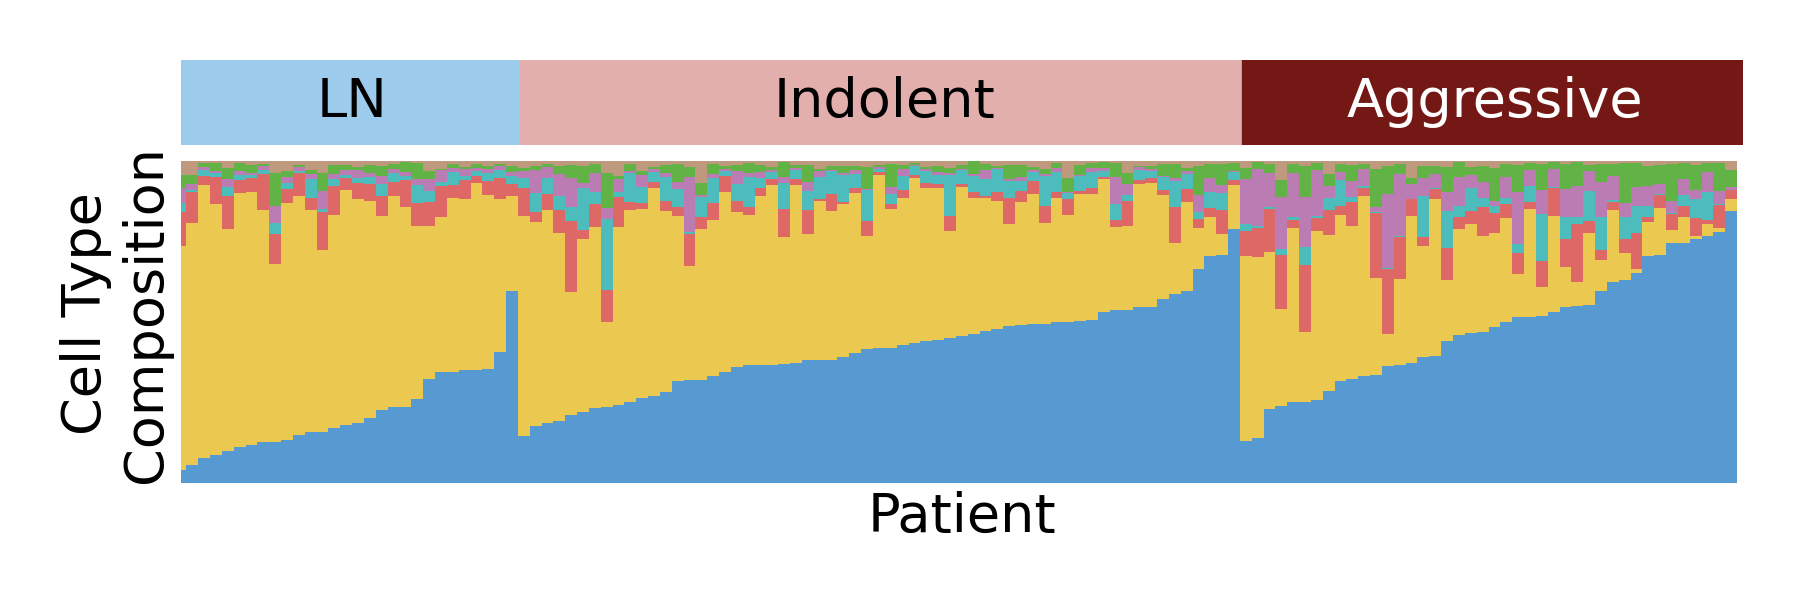

In [11]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_entity_class_overview(ax):
    entity_column = 'Entity_Class'
    entity_color_map = celltype_abundance_df[entity_column].map(entity_class_colors)
    for i, color in enumerate(entity_color_map):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))

    # Compute spans for each entity
    entity_groups = celltype_abundance_df.groupby(entity_column).indices
        
    # Add centered text for each entity
    for i, (entity, indices) in enumerate(entity_groups.items()):
        if len(indices) == 0:
            continue
        start = min(indices)
        end = max(indices) + 1
        center = (start + end) / 2
        count = len(indices)
        text_color = "white" if i == 2 else "black"
        ax.text(
            center,
            0.5,
            f"{entity[0].upper() + entity[1:]}",
            ha="center",
            va="center",
            color=text_color,
            rotation=0  # Horizontal text
        )

    ax.set_xlim(0, len(celltype_abundance_df))
    ax.set_ylim(0, 1)
    # Remove the borders
    ax.spines['top'].set_visible(False)    
    ax.spines['right'].set_visible(False)  
    ax.spines['left'].set_visible(False)   
    ax.spines['bottom'].set_visible(False) 
    # Optionally, hide ticks if desired
    ax.set_xticks([])
    ax.set_yticks([])

def plot_ct_abundance_overview(ax):
    celltype_abundance_df[celltype_colors.keys()].plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=celltype_colors,
        legend=False,
        width=1
    )
    ax.set_xlim(0, len(celltype_abundance_df))
    # Remove the borders
    ax.spines['top'].set_visible(False)    
    ax.spines['right'].set_visible(False)  
    ax.spines['left'].set_visible(False)   
    ax.spines['bottom'].set_visible(False) 
    # Optionally, hide ticks if desired
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Patient', fontsize=font_size)
    ax.set_ylabel('Cell Type\nComposition', fontsize=font_size)

fig = plt.figure(figsize=(3, 1), dpi=600)

# Define grid with custom heights for horizontal layout
gs = gridspec.GridSpec(2, 1, height_ratios=[0.5, 2], hspace=0.0)  # Adjust spacing

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

# Plot functions
plot_entity_class_overview(ax0)
plot_ct_abundance_overview(ax1)
plt.tight_layout()

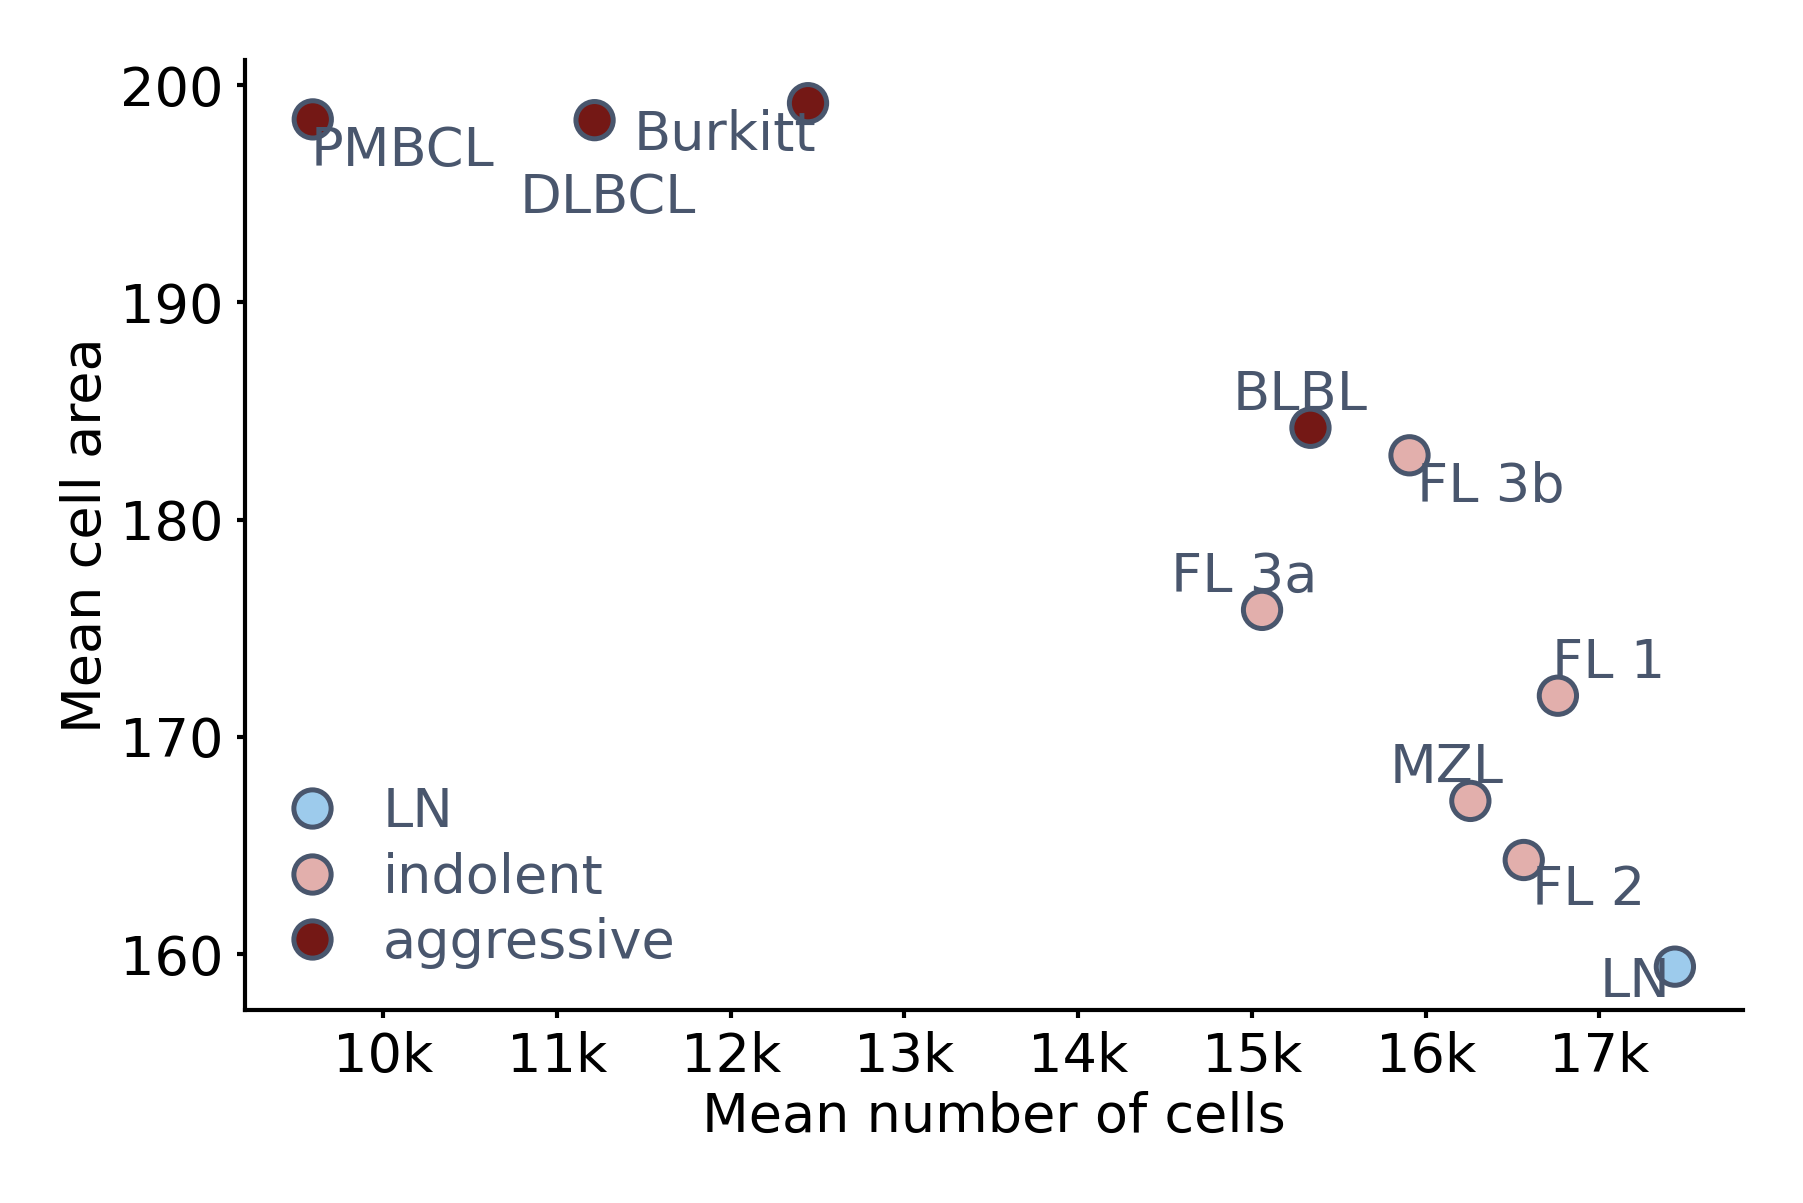

In [12]:
# Format x-axis ticks to show 8k, 10k, etc.
def format_ticks(x, pos):
    if x >= 1000:
        return f'{int(x/1000)}k'
    return str(int(x))    

def plot_cell_sizes(ax):
    sns.scatterplot(
        df_degree_size, 
        x='num_cells', 
        y='area', 
        hue='entity_class', 
        palette=entity_class_colors, 
        legend=True,
        ax=ax,
        s=point_size,
        edgecolor=point_border_color,
        linewidth=line_width
    )

    # Add labels for each point
    texts = []
    for _, row in df_degree_size.iterrows():
        texts.append(
            ax.text(
                row['num_cells'], 
                row['area'], 
                row['entity'], 
                ha='center', 
                va='center',
                color=point_border_color,
                fontsize=font_size  # Ensure consistency
            )
        )

    # Adjust text positions to avoid overlap
    adjust_text(texts, arrowprops=dict(), ax=ax)

    # Format tick labels
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))

    # Remove the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Set labels with consistent font size
    ax.set_xlabel('Mean number of cells', fontsize=font_size)
    ax.set_ylabel('Mean cell area', fontsize=font_size)

    # Set tick label size
    ax.tick_params(axis='both', labelsize=font_size)

    ax.set_yticks([160, 170, 180, 190, 200])
    
    legend = ax.legend(loc='lower left', fontsize=font_size, frameon=False)
    for text in legend.get_texts():
        text.set_color(point_border_color)


plt.figure(figsize=(3, 2), dpi=600)
ax = plt.gca()
plot_cell_sizes(ax)
plt.tight_layout()

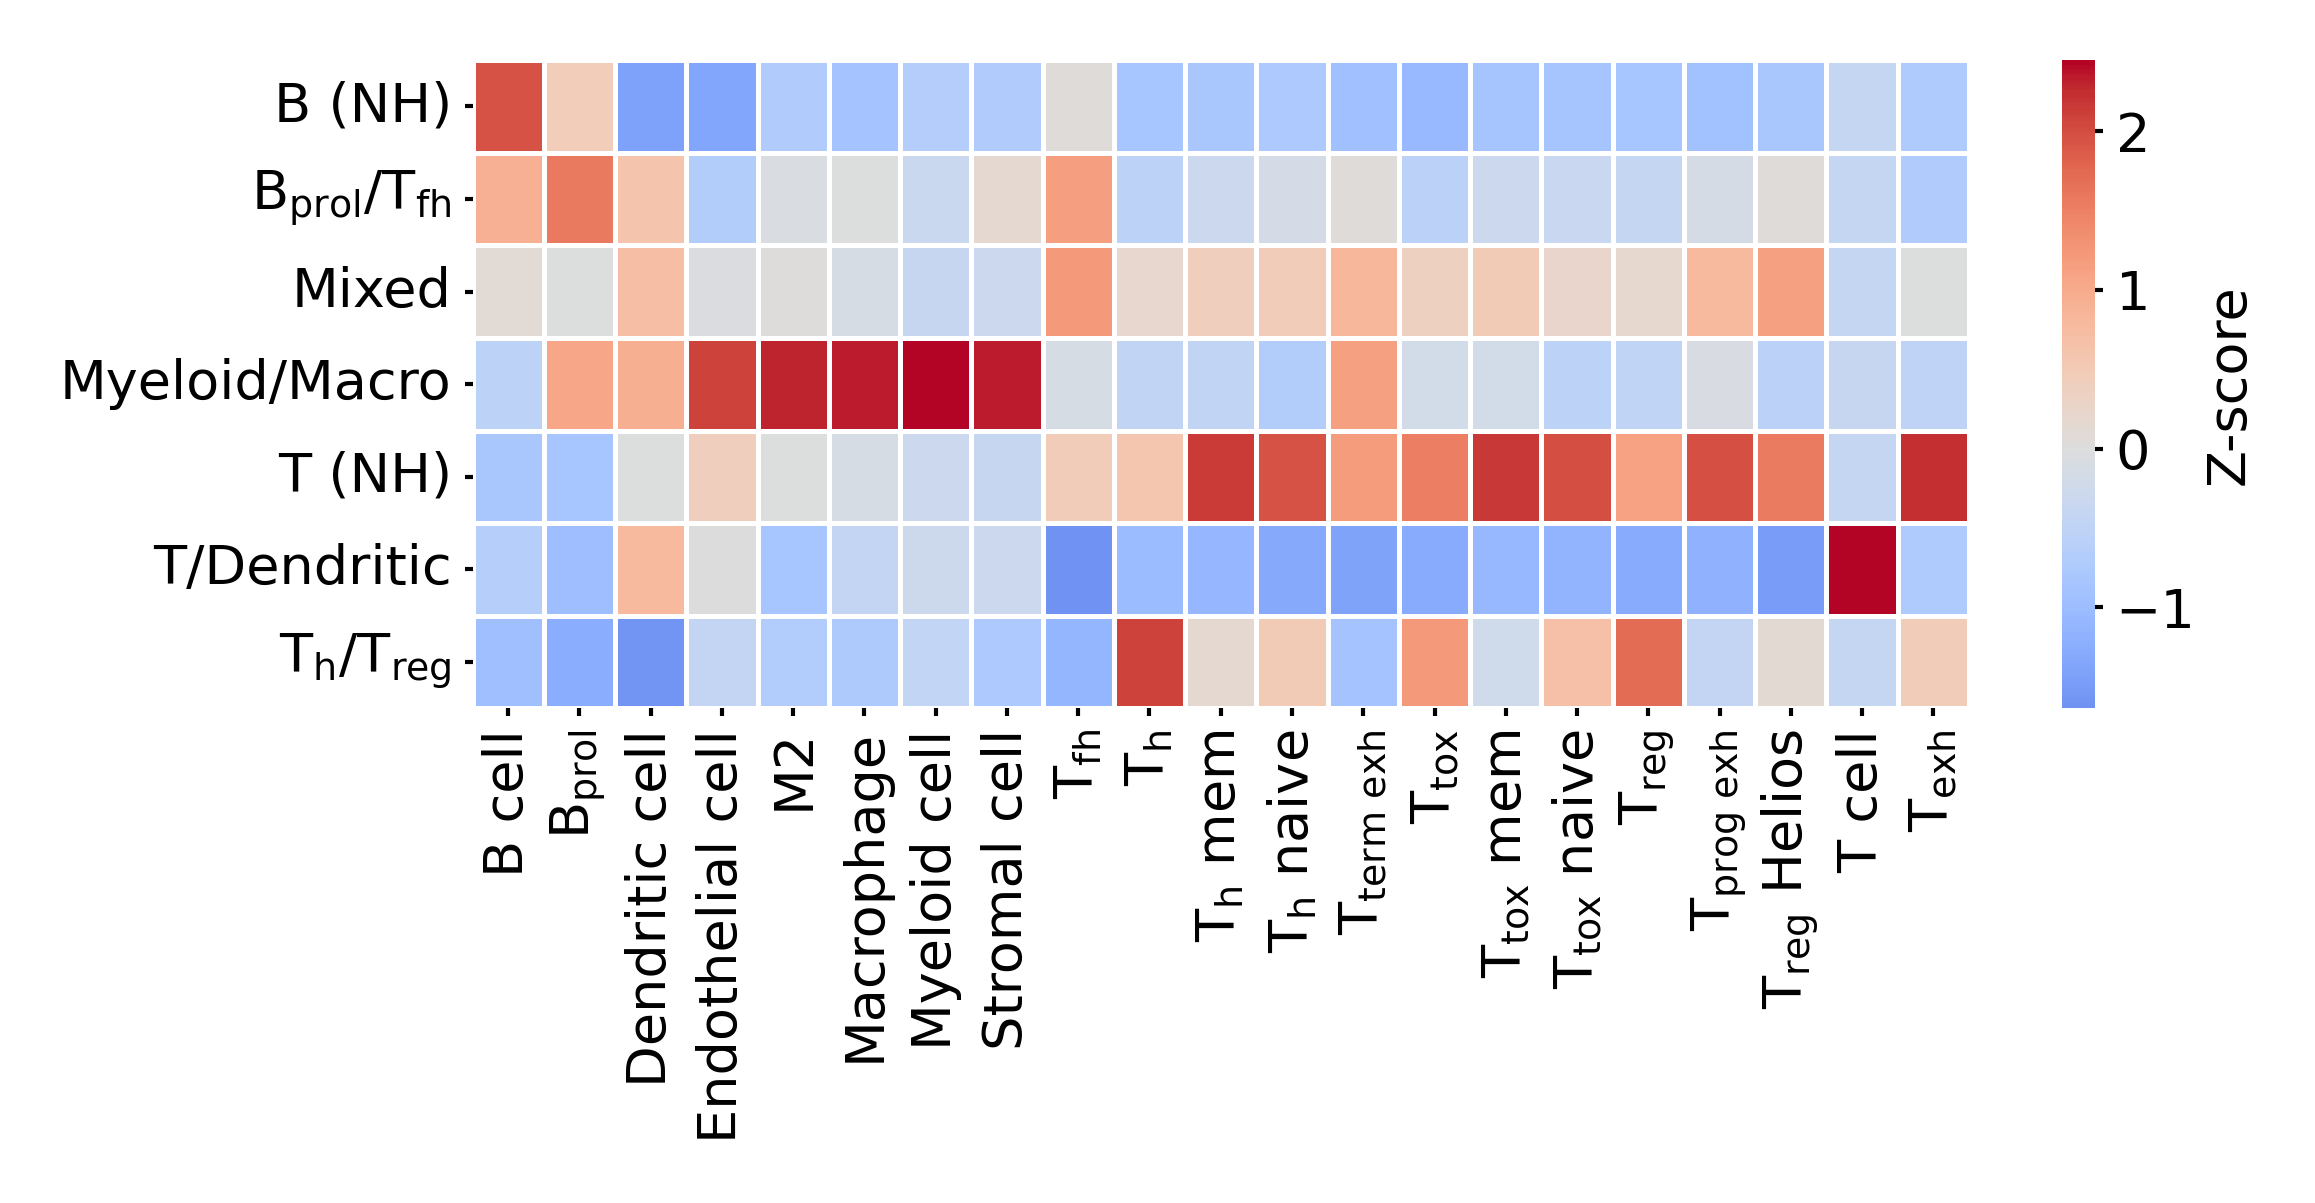

In [13]:
formatted_dict = {
    'B cell': 'B cell',
    'B_prol': r'B$_{\mathrm{prol}}$',
    'Dendritic cell': 'Dendritic cell',
    'Endothelial cell': 'Endothelial cell',
    'M2': 'M2',
    'Macrophage': 'Macrophage',
    'Myeloid cell': 'Myeloid cell',
    'Stromal cell': 'Stromal cell',
    'T_fh': r'T$_{\mathrm{fh}}$',
    'T_h': r'T$_{\mathrm{h}}$',
    'T_h_mem': r'T$_{\mathrm{h}}$ mem',
    'T_h_naive': r'T$_{\mathrm{h}}$ naive',
    'T_terminally_exh': r'T$_{\mathrm{term\ exh}}$',
    'T_tox': r'T$_{\mathrm{tox}}$',
    'T_tox_mem': r'T$_{\mathrm{tox}}$ mem',
    'T_tox_naive': r'T$_{\mathrm{tox}}$ naive',
    'T_reg': r'T$_{\mathrm{reg}}$',
    'T_progenitor_exh': r'T$_{\mathrm{prog\ exh}}$',
    'T_reg_Helios': r'T$_{\mathrm{reg}}$ Helios',
    'T cell': 'T cell',
    'T_exh': r'T$_{\mathrm{exh}}$'
}

nh_dict = {
    'B': 'B (NH)', 
    'B_prol/T_fh': r'B$_{\mathrm{prol}}$/T$_{\mathrm{fh}}$', 
    'Mixed': 'Mixed', 
    'Myeloid/Macro': 'Myeloid/Macro', 
    'T': 'T (NH)', 
    'T/Dendritic': 'T/Dendritic',
    'T_h/T_reg': r'T$_{\mathrm{h}}$/T$_{\mathrm{reg}}$'
}


def plot_neighborhood_composition(ax):
    heatmap = sns.heatmap(
        nh_composition_df,
        cmap="coolwarm",
        #cbar_pos=(1.02, 0.2, 0.03, 0.77),  # Position the colorbar to the right of the heatmap
        annot=False,  # No annotation
        center=0,  # Setting the center of the colorbar to 0
        linewidth=line_width,
        ax=ax
    )
    
    # Set colorbar title
    cbar = heatmap.collections[0].colorbar
    cbar.set_label("Z-score", fontsize=font_size)
    cbar.ax.tick_params(labelsize=font_size)
    
    ax.set_ylabel('')
    
    # Get current x-tick labels
    xtick_labels = [label.get_text() for label in ax.get_xticklabels()]
    # Replace with formatted labels from dictionary
    formatted_labels = [formatted_dict.get(label, label) for label in xtick_labels]
    # Set the new x-tick labels
    ax.set_xticklabels(formatted_labels, fontsize=font_size)
    
    # Get current y-tick labels
    ytick_labels = [label.get_text() for label in ax.get_yticklabels()]
    # Replace with formatted labels from dictionary
    formatted_labels = [nh_dict.get(label, label) for label in ytick_labels]
    # Set the new x-tick labels
    ax.set_yticklabels(formatted_labels, fontsize=font_size)
    
    # rotating the x tick labels
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        label.set_horizontalalignment('center')  # or 'left', 'center'
        label.set_verticalalignment('top')  # or 'bottom', 'center'
    ax.tick_params(axis='both', labelsize=font_size)
        
plt.figure(figsize=(4, 2), dpi=600)
ax = plt.gca()
plot_neighborhood_composition(ax)
plt.tight_layout()

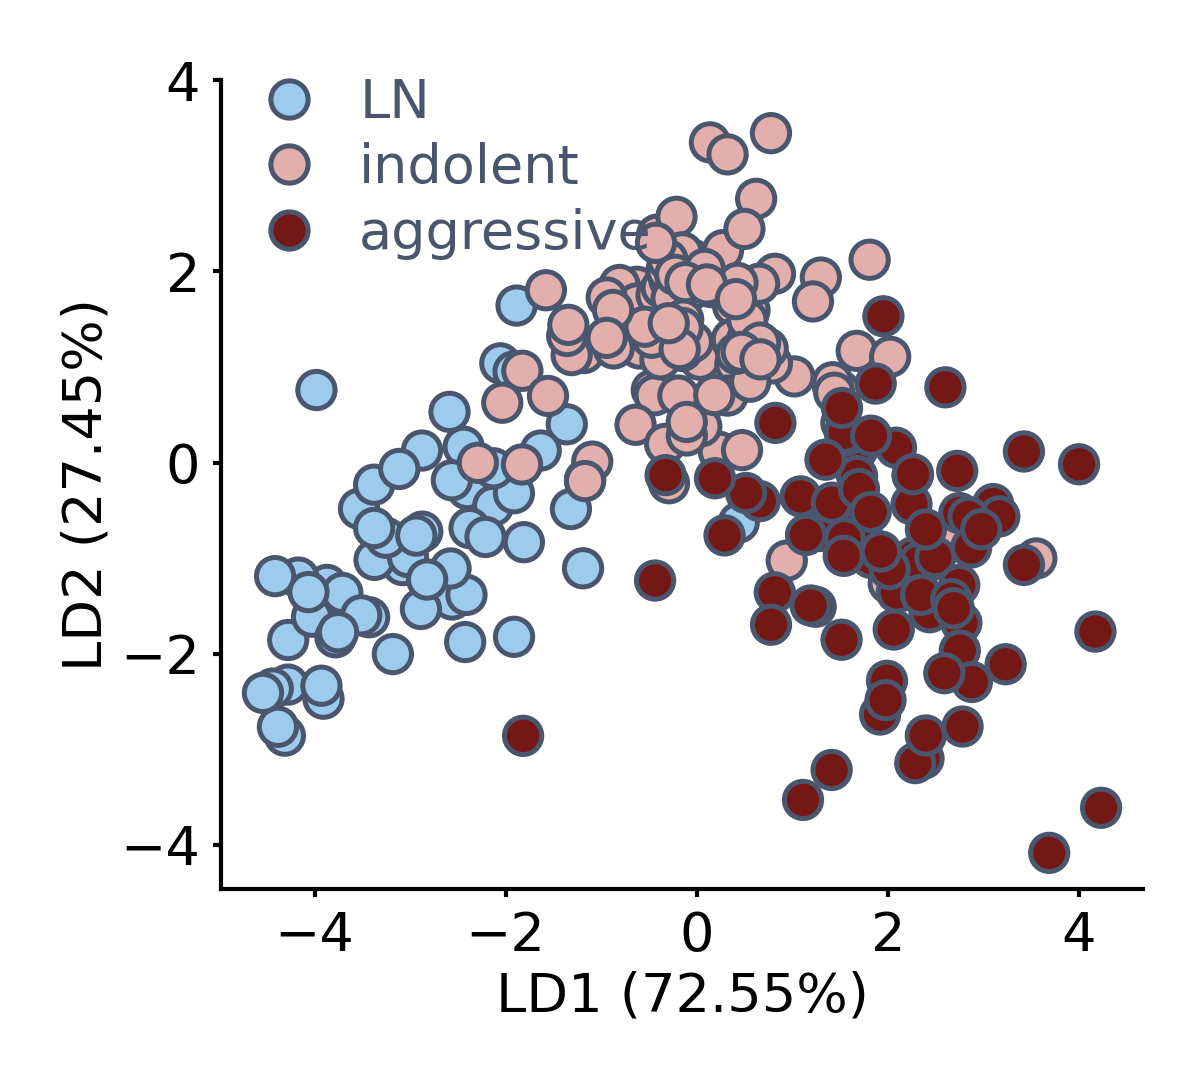

In [14]:
def plot_lda(ax):
    sns.scatterplot(data=lda_df, x='LD1', y='LD2', hue='entity_class', palette=entity_class_colors, s=point_size, ax=ax, legend=True, edgecolor=point_border_color, linewidth=line_width)
    ax.set_xlabel(f'LD1 ({lda_explained_variance.iloc[0,0]:.2f}%)', fontsize=font_size)
    ax.set_ylabel(f'LD2 ({lda_explained_variance.iloc[1,0]:.2f}%)', fontsize=font_size)
    
    # Force x and y units to be equal
    ax.set_aspect('equal')
    
    # Remove the right and top splines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_yticks([-4, -2, 0, 2, 4])
    ax.tick_params(axis='both', labelsize=font_size)
    
    legend = ax.legend(loc='upper left', bbox_to_anchor=(0, 1.055), fontsize=font_size, frameon=False)
    for text in legend.get_texts():
        text.set_color(point_border_color)
    
plt.figure(figsize=(2, 2), dpi=600)
ax = plt.gca()
plot_lda(ax)
plt.tight_layout()

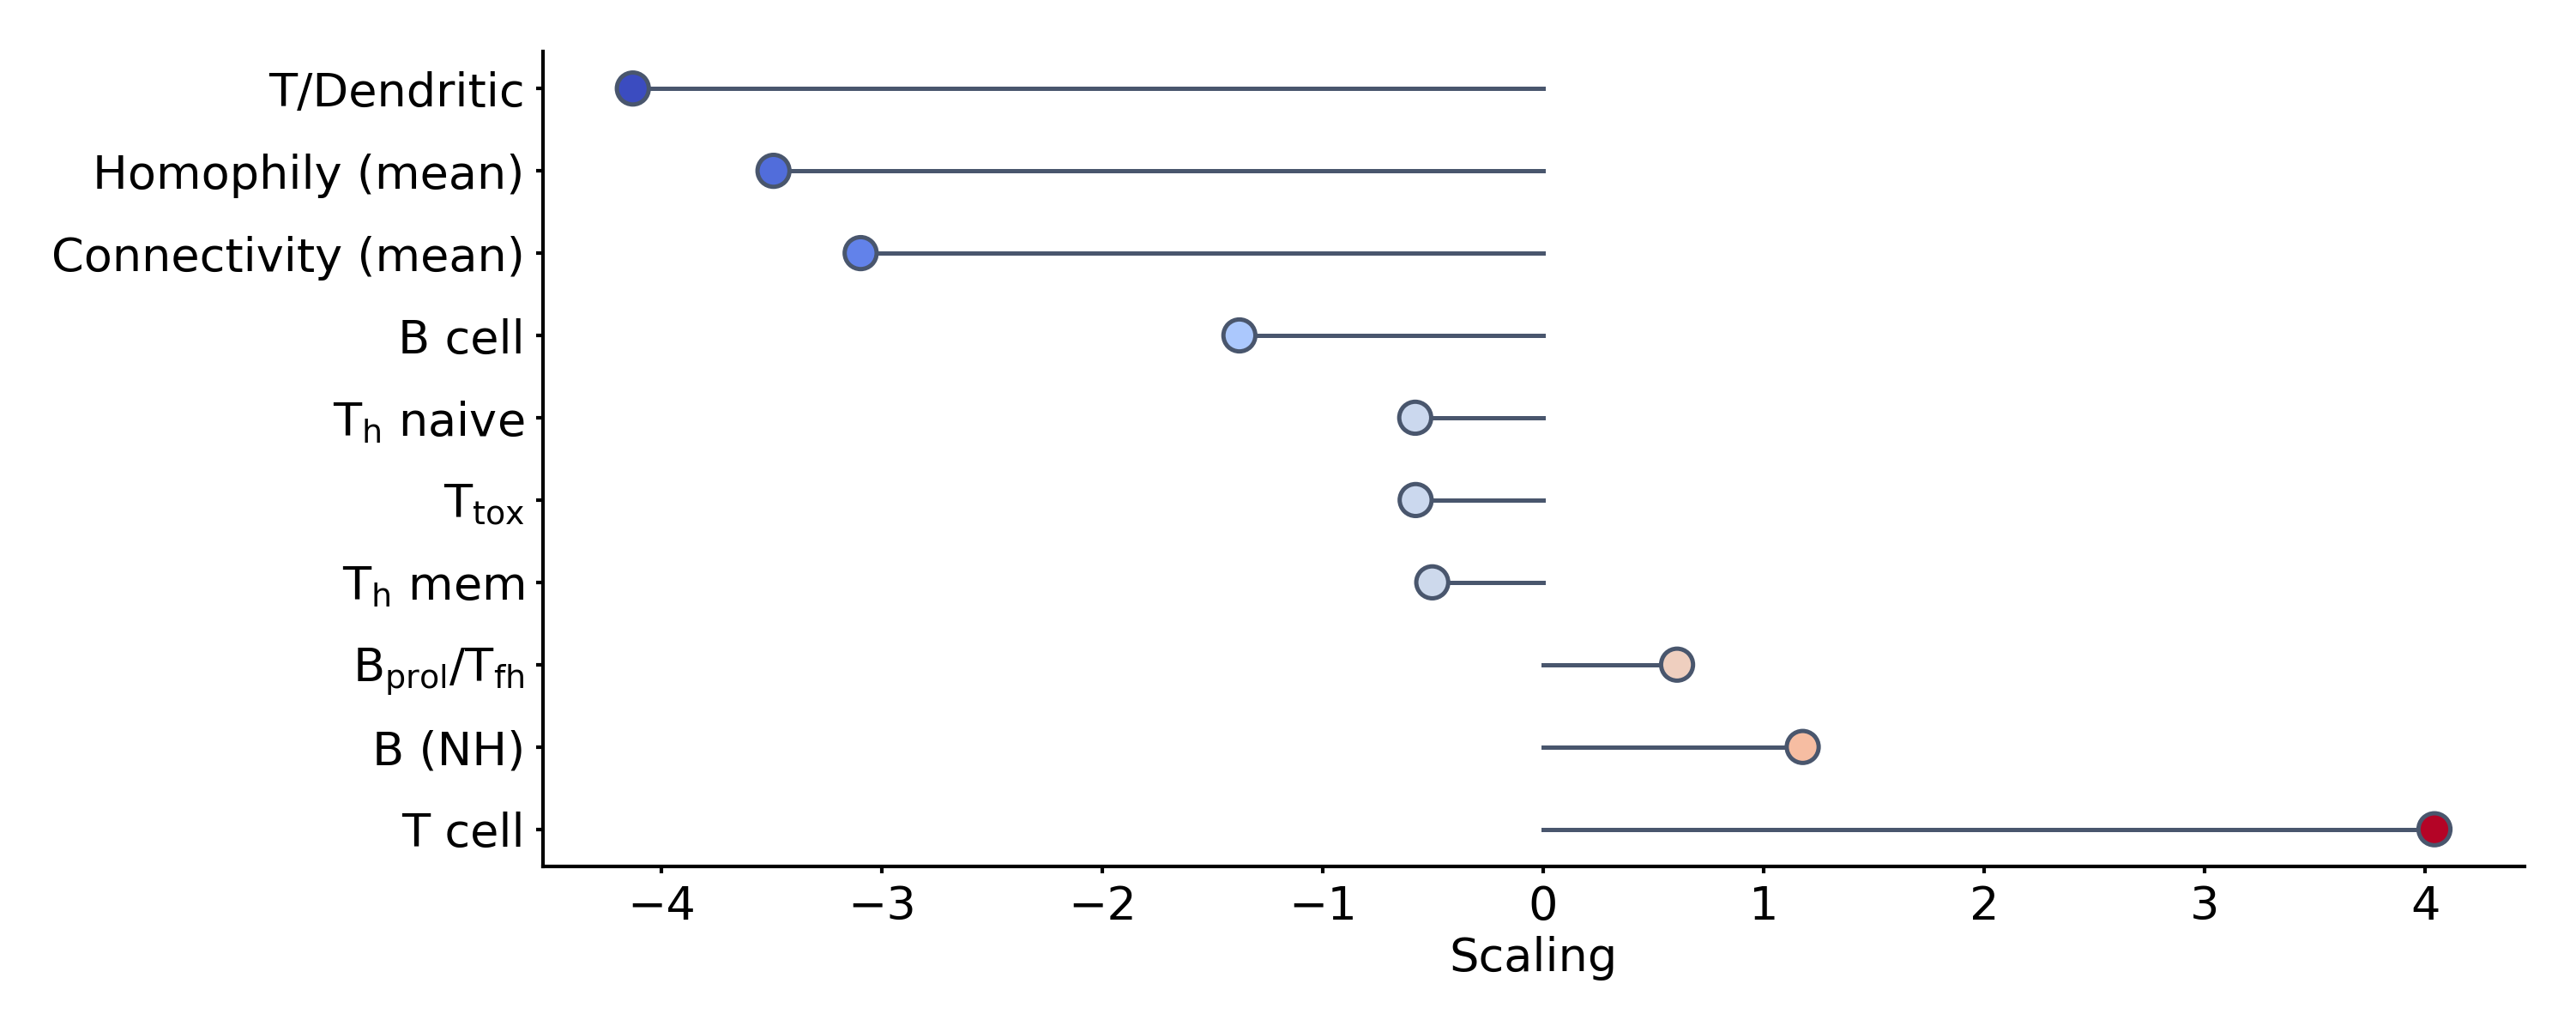

In [15]:
def plot_lda_loadings(ax):
    # Filter out rows where the absolute value of LD1 is below 0.5
    filtered_df = lda_loading_df[lda_loading_df['LD1'].abs() >= 0.5]
    
    # Get the color map
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    
    # Normalize the data for coloring
    norm = plt.Normalize(vmin=filtered_df['LD1'].min(), vmax=filtered_df['LD1'].max())

    # Set y-ticks to match the index and center them vertically
    y_positions = np.arange(len(filtered_df))
    ax.set_yticks(y_positions)
    ax.set_yticklabels(filtered_df.index)

    # Draw lines from 0 to the value for each point (ensure lines are behind points)
    for i, row in enumerate(filtered_df.itertuples()):
        ax.plot([0, row.LD1], [i, i], color=point_border_color, lw=line_width, zorder=1)

    # Scatter plot using Seaborn
    sns.scatterplot(
        data=filtered_df,
        x="LD1",
        y=y_positions,
        hue="LD1",
        palette=cmap,
        edgecolor=point_border_color,
        size=point_size,
        sizes=(point_size, point_size),
        linewidth=line_width,
        legend=False,
        ax=ax
    )

    # Set labels
    ax.set_xlabel('Scaling', fontsize=font_size)
    ax.set_ylabel('')
    
    # renaming for more concise figure
    nh_dict['Inter-label connectivity (mean)'] = 'Connectivity (mean)'
    tmp_dict = nh_dict.update(formatted_dict)
    # Get current y-tick labels
    ytick_labels = [label.get_text() for label in ax.get_yticklabels()]
    # Replace with formatted labels from dictionary
    formatted_labels = [nh_dict.get(label, label) for label in ytick_labels]
    # Set the new x-tick labels
    ax.set_yticklabels(formatted_labels, fontsize=font_size)
    
    # Remove the right and top splines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.tick_params(axis='both', labelsize=font_size)
    
plt.figure(figsize=(5, 2), dpi=600)
ax = plt.gca()
plot_lda_loadings(ax)
plt.tight_layout()

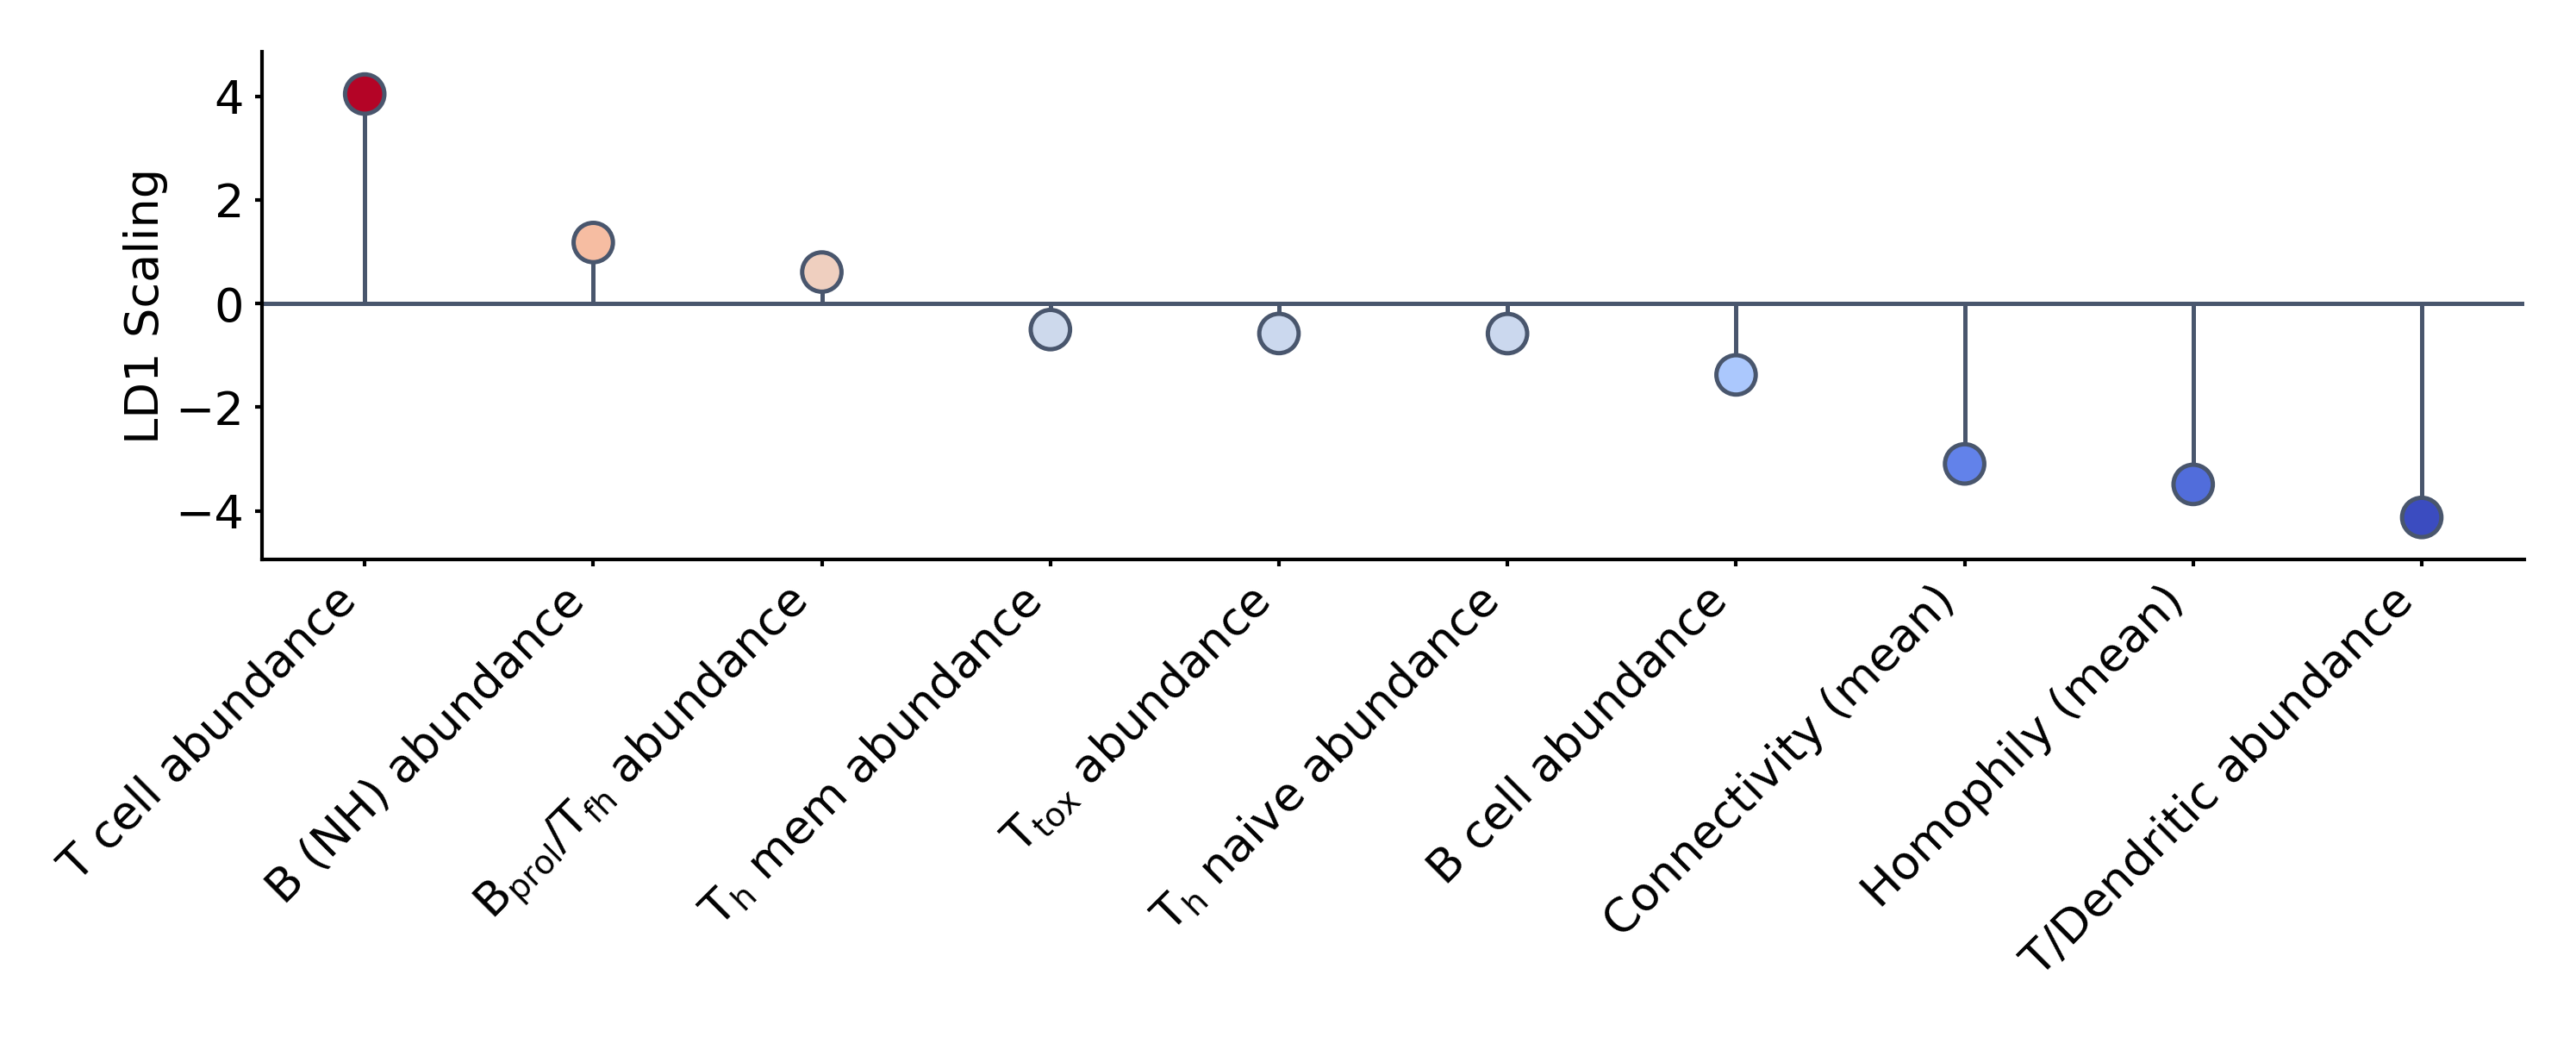

In [16]:
def plot_lda_loadings(ax):
    # Filter rows by LD1 threshold
    filtered_df = lda_loading_df[lda_loading_df['LD1'].abs() >= 0.5]

    # Apply label formatting dictionary early
    nh_dict['Inter-label connectivity (mean)'] = 'Connectivity (mean)'
    nh_dict.update(formatted_dict)  # Apply formatting

    # Prepare x-axis positions and labels
    x_positions = np.arange(len(filtered_df))
    raw_labels = filtered_df.index.tolist()
    formatted_labels = [nh_dict.get(label, label) for label in raw_labels]
    # adding "abundance" to the cell types and neighborhoods
    formatted_labels = [f"{x} abundance" if not x.endswith('(mean)') else x for x in formatted_labels]

    # Color mapping setup
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    norm = plt.Normalize(vmin=filtered_df['LD1'].min(), vmax=filtered_df['LD1'].max())

    # Lines from 0 to value (background layer)
    for i, row in enumerate(filtered_df.itertuples()):
        ax.plot([i, i], [0, row.LD1], color=point_border_color, lw=line_width, zorder=1)
        
    # Add y=0 line
    ax.axhline(0, color=point_border_color, linewidth=line_width, zorder=1)

    # Scatter points
    sns.scatterplot(
        x=x_positions,
        y=filtered_df['LD1'],
        hue=filtered_df['LD1'],
        palette=cmap,
        edgecolor=point_border_color,
        size=point_size,
        sizes=(point_size+10, point_size+10),
        linewidth=line_width,
        legend=False,
        ax=ax
    )

    # Set labels and ticks
    ax.set_xticks(x_positions)
    ax.set_xticklabels(formatted_labels, rotation=45, ha='right', fontsize=font_size)
    ax.set_xlabel('')
    ax.set_ylabel('LD1 Scaling', fontsize=font_size)

    # Set specific y-ticks
    ax.set_yticks([-4, -2, 0, 2, 4])

    # Add y-axis padding
    y_min, y_max = filtered_df['LD1'].min(), filtered_df['LD1'].max()
    y_range = y_max - y_min
    ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

    # Style
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', labelsize=font_size)
    
plt.figure(figsize=(5, 2), dpi=600)
ax = plt.gca()
plot_lda_loadings(ax)
plt.tight_layout()